# Emotion Detector

## Import Library

In [46]:
import numpy as np
import pandas as pd
import tensorflow 
import cv2 as cv
tensorflow.config.experimental.set_memory_growth(tensorflow.config.list_physical_devices()[2], True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, LeakyReLU, ReLU, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.applications as models
from keras.optimizers import RMSprop, SGD
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
import os
face_classifier = cv.CascadeClassifier(r'C:\anaconda3\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')

## Data Fetching and Augmentation

In [2]:
im_size = 224 # Image Size
dim = (im_size, im_size, 3) # Image Dimension
bs = 32 # Batch Size

In [10]:
train_dir = r'D:/Datasets/emotion/train'
val_dir = r'D:/Datasets/emotion/val'

In [11]:
train_gen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.2, zoom_range = 0.2,
                               fill_mode = "nearest", rescale = 1/255, horizontal_flip = False, vertical_flip = False)

val_gen = ImageDataGenerator(rescale = 1/255)

In [12]:
train = train_gen.flow_from_directory(train_dir, target_size = (im_size, im_size), batch_size = bs, class_mode = 'categorical') 

val = val_gen.flow_from_directory(val_dir, target_size = (im_size, im_size), batch_size = bs, class_mode = 'categorical') 

Found 3563 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


## Function for Face Detection

In [3]:
def face_extractor(img):
    faces = face_classifier.detectMultiScale(img, 1.3, 5)
    
    if faces is ():
        return None
    
    for (x,y,w,h) in faces:
        x=x-10
        y=y-10
        cropped_face = img[y:y+h+50, x:x+w+50]

    return cropped_face

<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-3-c8d83636406a>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


## If you must custom Data Set, can use this code

In [ ]:
cap = cv.VideoCapture(0) # Capture from webcam
try:
    if count != 0:
        pass
except:
    count = 0
stop = 0

while True:

    ret, frame = cap.read()
    if face_extractor(frame) is not None:
        count += 1
        stop += 1
        face = cv.resize(face_extractor(frame), (im_size, im_size))

        # Save file in specified directory with unique name
        file_name_path = r'D:\Datasets\emotion\val\normal\\'  + str(count) + '.jpg' 
        cv.imwrite(file_name_path, face)

        # Put count on images and display live count
        cv.putText(face, str(count), (50, 50), cv.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        cv.imshow('Face Cropper', face)
        
    else:
        print("Face not found")
        pass

    if cv.waitKey(1) = ord('q') or stop == 500: #q is the Enter Key
        break
        
cap.release()
cv.destroyAllWindows()      
print("Collecting Samples Complete")

## Building Model

In [14]:
base_model = models.VGG19(include_top = False, weights = 'imagenet', input_shape = dim, classes = train.num_classes)

model = Sequential()

model.add(base_model) 

model.add(Flatten()) 

model.add(Dense(1024, activation = ('relu'), input_dim = 512))

model.add(Dense(512, activation = ('relu'))) 

model.add(Dense(256, activation = ('relu'))) 

model.add(Dense(128, activation = ('relu')))

model.add(Dense(train.num_classes, activation = ('softmax')))

sgd = SGD(lr = .001, momentum = .9, nesterov = False)

model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                

## Training Model

In [15]:
earlystoping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, mode = 'min',
  baseline=None, restore_best_weights = True)

lrr = ReduceLROnPlateau(monitor = 'val_loss', factor = .01,  patience = 5, min_lr = 1e-5)

history = model.fit(train, steps_per_epoch = 25, validation_data = val, validation_steps = 12, epochs  = 150,
                verbose = 1, callbacks = [earlystoping, lrr], batch_size = 32)

Epoch 1/150
25/25 [==============================] - 24s 972ms/step - loss: 0.5625 - accuracy: 0.8050 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 2/150
25/25 [==============================] - 25s 1s/step - loss: 0.3405 - accuracy: 0.8975 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 3/150
25/25 [==============================] - 28s 1s/step - loss: 0.0135 - accuracy: 0.9975 - val_loss: 0.0070 - val_accuracy: 0.9974
Epoch 4/150
25/25 [==============================] - 27s 1s/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 3.8548e-04 - val_accuracy: 1.0000
Epoch 5/150
25/25 [==============================] - 26s 1s/step - loss: 6.8198e-04 - accuracy: 1.0000 - val_loss: 7.0140e-05 - val_accuracy: 1.0000
Epoch 6/150
25/25 [==============================] - 26s 1s/step - loss: 0.0014 - accuracy: 0.9987 - val_loss: 1.6919e-04 - val_accuracy: 1.0000
Epoch 7/150
25/25 [==============================] - 26s 1s/step - loss: 2.8837e-04 - accuracy: 1.0000 - val_loss: 7.6371e-05 - val_acc

## Saving Model

In [18]:
model.save('emotion')

INFO:tensorflow:Assets written to: emotion\assets


## Loading Model

In [4]:
model = load_model('emotion')

## Testing Using Webcam

In [43]:
def classifier(pred): # Simple Function for class defination
    if pred[0] > 0.5:
        state = 'Laughing'

    if pred[1] > 0.5:
        state = 'Neutral'    

    if pred[2] > 0.5:
        state = 'Smiling'
    return state

In [44]:
video_capture = cv.VideoCapture(0)

while True:
    _, frame = video_capture.read()
    try:
        face = face_extractor(frame)

        if type(face) is np.ndarray:
            face = cv.resize(face, (im_size, im_size))
            im = Image.fromarray(face, 'RGB')
            img_array = np.array(im)

            img_array = np.expand_dims(img_array, axis = 0)
            pred = model.predict_proba(img_array)[0]

            name = classifier(pred)

            cv.putText(frame,name, (50, 50), cv.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        else:
            cv.putText(frame,"Cannot Classify", (50, 50), cv.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)

        cv.imshow('Video', frame)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break
            
    except:
        cv.putText(frame,"Error", (50, 50), cv.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
        
video_capture.release()
cv.destroyAllWindows()

In [68]:
def tester(img_file_path):
    plt.figure(figsize = (10, 5))
    test_img = img_file_path
    test_img = imread(test_img)
    face = face_extractor(test_img)
    if type(face) is np.ndarray:
        face = cv.resize(face, (im_size, im_size))
        im = Image.fromarray(face, 'RGB')
        img_array = np.array(im)
    
    imshow(img_array)

    img = np.expand_dims(img_array, axis = 0)
    pred = model.predict_proba(img)[0]
    plt.title(classifier(pred))
    plt.show()

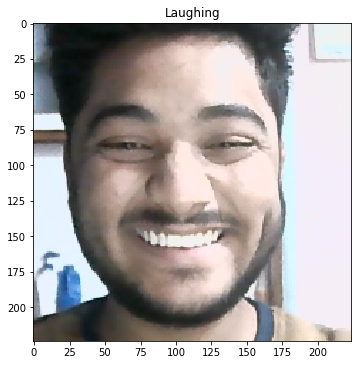

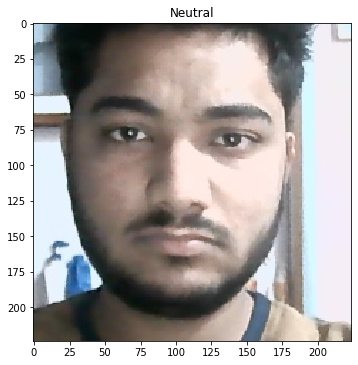

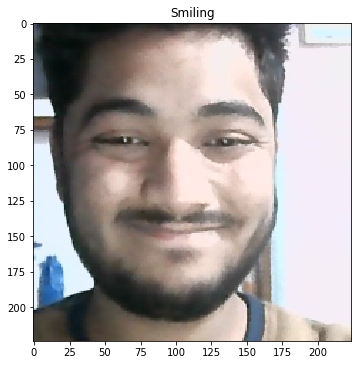

In [69]:
test_imgs = r'D:\Datasets\emotion'
images = os.listdir(test_imgs)
for img in images:
    test_img_path = test_imgs + '//' + img
    if test_img_path.endswith('.jpg'):
        tester(test_img_path)

## Conclusion -
- Model can be improved by using more Deep Nural Networks(if one have resources at disposal).
- Better Prediction using better Camera/Images
- Increasing Dataset size can be benefical.